---
---

<h1><center><ins>Numerical methods: exam 2</ins></center></h1>
<h2><center>4th of of February, 9:45-11:15<br><br>

---
---

## Exercise 1 (9 points) - The leapfrog algorithm:

Imagine that someone dropped a ball which is now falling on the ground from the height of 100 meters. 

**(A)** Create the set of ODEs for the distance travelled and the velocity of the ball. Initial conditions: the height $h = 100$ meters, the initial velocity is zero. The acceleration of the free fall is $a$.

**(B)** Solve this coupled set of ODEs with **your own leapfrog** implementation. Use the following step size: $\Delta t = 0.1$ seconds. Include a check if the ball has hit the ground.

**(C)** Plot the numerical solution for $a = 3.7$ meters/second (the freefall acceleration on Mars). Calculate and output the time at the step when the altitude becomes zero (the ball has hit the ground).

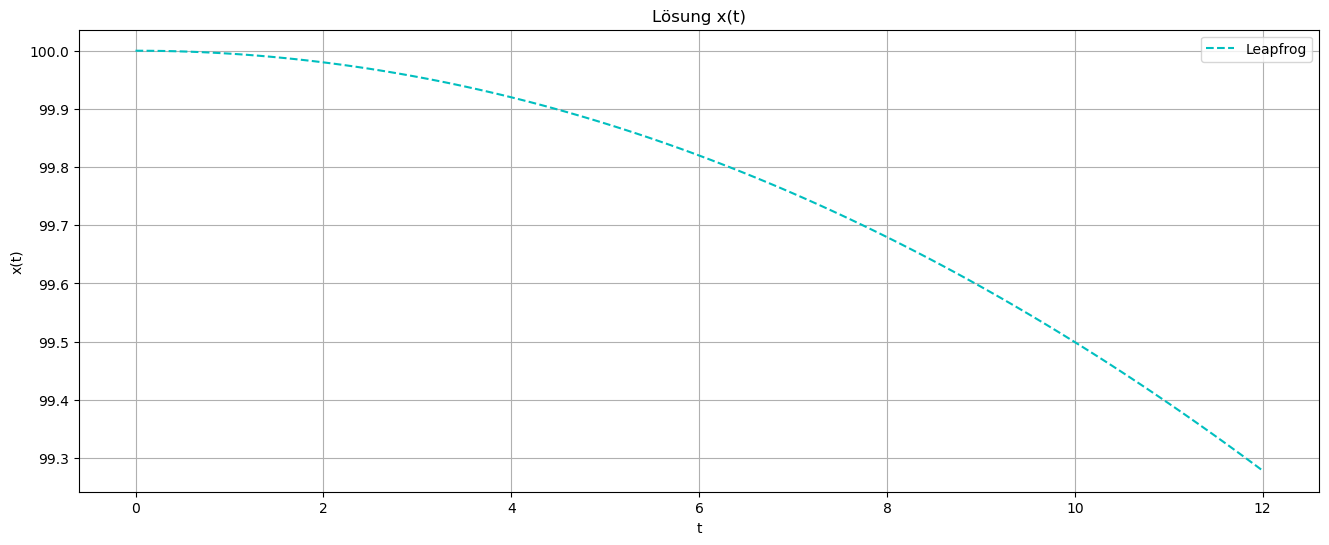

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### A
#dxdt = v
#dvdt = a
#v0 + a*t

def rhs_ODE(t, y, GM): 
    x, v = y
    dxdt = v
    dvdt = -GM / (x**2)
    return np.array([dxdt, dvdt])

def leapfrog_simple(rhs_ODE, y0, t_max, h, GM): 
    
    N_total = int(t_max / h)
    t = np.linspace(0.0, N_total * h, N_total + 1)
    # y ist ein 2D-Array: jede Zeile ist der Zustand [x,v] zum Zeitpunkt t[n]
    y = np.zeros((N_total + 1, len(y0)))
    y[0] = y0

    # Hauptschleife über alle Zeitschritte
    for n in range(N_total):
        
        x = y[n, 0]
        v = y[n, 1]

        tn  = t[n]
        tn1 = t[n+1]
     
        # Update Regel für Leapfrog für x
        # x[i+1] = x[i] + v[i]*Delta t + 1/2 a[i] * Delta t^2

        # Berechnen v' = a zum Zeitpunkt t[n], also a[i] in der Update-Regel
        a_n = rhs_ODE(tn, y[n],GM)[1]

        # Schreiben neuen Wert von x (also x[i+1]) in Variable x_new
        x_new = x + v*h + 0.5*a_n*h*h

        # Update Regel für Leapfrog für v
        # v[i+1] = v[i] + 1/2*(a[i] + a[i+1]) * Delta t
    
        mixed = np.array([x_new, v])
        a_n1 = rhs_ODE(tn1, mixed, GM)[1] 
        
        v_new = v + 0.5*(a_n + a_n1)*h

        # neuen Zustand speichern
        y[n+1, 0] = x_new
        y[n+1, 1] = v_new

    return t, y

#---Main Program-----
# Parameter für zu lösende ODE zweiter Ordnung

GM = 100

# Startwerte für x(t=0) und v(t=0)
x0 = 100.0   # Startabstand
v0 = 0.0   # Startgeschwindigkeit
y0 = np.array([x0, v0])

# Parameter für die Integration
# Bis wohin soll die Lösung berechnet werden?
# wird angenommen: t_start = 0
t_max = 12.0 # bei t_max > ca 12.5 wird der Abstand gleich 0 und die Lösungen unphysikalisch

#Mit welcher Schrittweite Delta t (=h) soll gerechnet werden
h = 0.1

t_lf, y_lf = leapfrog_simple(rhs_ODE, y0, t_max, h, GM) 

plt.figure(figsize=(16, 6))

plt.plot(t_lf, y_lf[:, 0],  'c--', label='Leapfrog')

plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Lösung x(t)')
plt.grid(True)
plt.legend()
plt.show()

## Exercise 2 (9 points) - FFT:

Fast Fourrier Transform can be used to search for radial velocity signals of exoplanets and to determine their periods. The file ```rv_hd69830_like.csv``` provides a mock radial velocity signal similar to the real RV signal of the star HD 69830 by HARPS on the ESO 3.6m telescope at La Silla.

**(A)** Load the datafile into your programme. Ignore the caption when creating numpy arrays.

**(B)** Using **embedded python functions** from the numpy library, search for periodic signals in this datafile. Before performing FFT, subtract the mean value from the signal to aviod contamination. **NB**: on a noisy dataset and without additional processing, the real frequecies can be displayed as several very close frequencies.

**(C)** Plot the power spectrum of the mock data.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.io import fits


dateiname="rv_hd69830_like.csv"

daten = np.loadtxt(dateiname, delimiter=",", skiprows=1)

dt = daten[:, 0] #time
y = daten[:, 1] #rv

flux = y - np.mean(flux)


def fft_signal(flux, dt):
    """ 
    FFT eines zeitlich äquidistant abgetasteten Signals

    Input:
        flux : Signalwerte
        dt   : Sampling-Intervall

    Output:
        freq      : Frequenzen (positive)
        power     : Leistungsspektrum |FFT|^2
        fft_vals  : komplexe FFT-Werte
    """

    flux = np.asarray(flux)

    # numpy.fft.fft liefert komplexe Fourier-Koeffizienten
    fft_vals = np.fft.fft(flux)
    
    # Zugehörige Frequenzen
    N = len(flux)
    freq = np.fft.fftfreq(N, d=dt)

    mask = freq > 0

    freq = freq[mask]
    fft_vals = fft_vals[mask]

    power = np.abs(fft_vals)**2

    return freq, power, fft_vals



# FUNKTION: DOMINANTE PERIODEN BESTIMMEN
def dominant_periods(freq, power, n_peaks=5):
    """
    Bestimmt die dominantesten Perioden im Signal.

    Input:
        freq     : Frequenzarray
        power    : Leistungsdichte
        n_peaks  : Anzahl der stärksten Peaks (standardmäßig auf 5 gesetzt
                   ACHTUNG: Oben in Funktionsdefinition ändern, wenn mehr gebraucht werden

    Output:
        periods  : dominante Perioden
        freqs    : zugehörige Frequenzen
    """

    idx = np.argsort(power)[::-1][:n_peaks]

    dominant_freqs = freq[idx]
    dominant_periods = 1.0 / dominant_freqs

    return dominant_periods, dominant_freqs




T = 300.0 # total baseline in days 

print("Baseline T [days]:", T)
print("dt [days]:", dt)

# FFT berechnen
freq, power, fft_vals = fft_signal(flux, dt)

# Dominante Perioden
periods, freqs = dominant_periods(freq, power, n_peaks=3)
#print("Dominante Frequenzen [1/day]:", freqs)
#print("Dominante Perioden [days]:", periods)

# --- Plot PSD ---
plt.figure(figsize=(7,4))
plt.scatter(dt, flux, s=5) #
plt.xlabel("Days")
plt.ylabel("Flux")
plt.title("Light Curve")
plt.show()

Baseline T [days]: 300.0
dt [days]: [  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5
  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5
  18.   18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5
  24.   24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5
  30.   30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5
  36.   36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5
  42.   42.5  43.   43.5  44.   44.5  45.   45.5  46.   46.5  47.   47.5
  48.   48.5  49.   49.5  50.   50.5  51.   51.5  52.   52.5  53.   53.5
  54.   54.5  55.   55.5  56.   56.5  57.   57.5  58.   58.5  59.   59.5
  60.   60.5  61.   61.5  62.   62.5  63.   63.5  64.   64.5  65.   65.5
  66.   66.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.   71.5
  72.   72.5  73.   73.5  74.   74.5  75.   75.5  76.   76.5  77.   77.5
  78.   78.5  7

<class 'NameError'>: name 'N' is not defined